In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from itertools import cycle
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *
import wandb
import utils

from thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss
from thirdparty.repdistiller.distiller_zoo import PKT, ABLoss, FactorTransfer, KDSVD, FSP, NSTLoss

from thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bad_teacher, train_bcu_distill, validate
from thirdparty.repdistiller.helper.pretrain import init

/tmp/ipykernel_770922/2672079530.py:24: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def pdb():
    import pdb
    pdb.set_trace

In [3]:
def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')
    return count

In [4]:
def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

In [5]:
def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

### Pre-training

In [6]:
#%run main.py --dataset cifar100 --dataroot=data/cifar-100-python --model resnet --filteers 0.4 --lr 0.1 --lossfn ce --num-classes 100

### Metrics

In [7]:
def activations_predictions(model,dataloader,name):
    criterion = torch.nn.CrossEntropyLoss()
    metrics,activations,predictions=get_metrics(model,dataloader,criterion,128,True)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']

    return activations,predictions

In [8]:
def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist

In [9]:
def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

### Membership Inference Attack

In [10]:
"""https://github.com/google-research/google-research/blob/master/learn_to_forget/membership_inference.py"""
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import random

def cm_score(estimator, X, y):
    y_pred = estimator.predict(X)
    cnf_matrix = confusion_matrix(y, y_pred)
    
    FP = cnf_matrix[0][1] 
    FN = cnf_matrix[1][0] 
    TP = cnf_matrix[0][0] 
    TN = cnf_matrix[1][1]


    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print (f"FPR:{FPR:.2f}, FNR:{FNR:.2f}, FP{FP:.2f}, TN{TN:.2f}, TP{TP:.2f}, FN{FN:.2f}")
    return ACC


def evaluate_attack_model(sample_loss,
                          members,
                          n_splits = 5,
                          random_state = None):
  """Computes the cross-validation score of a membership inference attack.
  Args:
    sample_loss : array_like of shape (n,).
      objective function evaluated on n samples.
    members : array_like of shape (n,),
      whether a sample was used for training.
    n_splits: int
      number of splits to use in the cross-validation.
    random_state: int, RandomState instance or None, default=None
      random state to use in cross-validation splitting.
  Returns:
    score : array_like of size (n_splits,)
  """

  unique_members = np.unique(members)
  if not np.all(unique_members == np.array([0, 1])):
    raise ValueError("members should only have 0 and 1s")

  attack_model = LogisticRegression()
  cv = StratifiedShuffleSplit(
      n_splits=n_splits, random_state=random_state)
  return cross_val_score(attack_model, sample_loss, members, cv=cv, scoring=cm_score)

def membership_inference_attack(model, t_loader, f_loader, seed):
    import matplotlib.pyplot as plt
    import seaborn as sns
    

    fgt_cls = list(np.unique(f_loader.dataset.targets))
    indices = [i in fgt_cls for i in t_loader.dataset.targets]
    t_loader.dataset.data = t_loader.dataset.data[indices]
    t_loader.dataset.targets = t_loader.dataset.targets[indices]

    
    cr = nn.CrossEntropyLoss(reduction='none')
    test_losses = []
    forget_losses = []
    model.eval()
    mult = 0.5 if args.lossfn=='mse' else 1
    dataloader = torch.utils.data.DataLoader(t_loader.dataset, batch_size=128, shuffle=False)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*cr(output, target)
        test_losses = test_losses + list(loss.cpu().detach().numpy())
    del dataloader
    dataloader = torch.utils.data.DataLoader(f_loader.dataset, batch_size=128, shuffle=False)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*cr(output, target)
        forget_losses = forget_losses + list(loss.cpu().detach().numpy())
    del dataloader

    np.random.seed(seed)
    random.seed(seed)
    if len(forget_losses) > len(test_losses):
        forget_losses = list(random.sample(forget_losses, len(test_losses)))
    elif len(test_losses) > len(forget_losses):
        test_losses = list(random.sample(test_losses, len(forget_losses)))
    
  
    sns.distplot(np.array(test_losses), kde=False, norm_hist=False, rug=False, label='test-loss', ax=plt)
    sns.distplot(np.array(forget_losses), kde=False, norm_hist=False, rug=False, label='forget-loss', ax=plt)
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title("loss histograms",size=18)
    plt.xlabel('loss values',size=14)
    plt.show()
    print (np.max(test_losses), np.min(test_losses))
    print (np.max(forget_losses), np.min(forget_losses))


    test_labels = [0]*len(test_losses)
    forget_labels = [1]*len(forget_losses)
    features = np.array(test_losses + forget_losses).reshape(-1,1)
    labels = np.array(test_labels + forget_labels).reshape(-1)
    features = np.clip(features, -500, 500)
    score = evaluate_attack_model(features, labels, n_splits=5, random_state=seed)

    return score
        
        

### Finetune and Fisher Helper

In [11]:
from utils import *
def get_metrics(model,dataloader,criterion,bs=128,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=128, shuffle=False)
    model.eval()
    metrics = utils.AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            #activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            activations = activations + list(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [12]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = utils.AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

def run_neggrad_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    forget_loader: torch.utils.data.DataLoader,
                    alpha: float,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    quiet=False):
    model.eval()
    metrics = utils.AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, (batch_retain,batch_forget) in enumerate(tqdm(zip(data_loader,cycle(forget_loader)), leave=False)):
            batch_retain = [tensor.to(next(model.parameters()).device) for tensor in batch_retain]
            batch_forget = [tensor.to(next(model.parameters()).device) for tensor in batch_forget]
            input_r, target_r = batch_retain
            input_f, target_f = batch_forget
            output_r = model(input_r)
            output_f = model(input_f)
            loss = alpha*(loss_fn(output_r, target_r) + l2_penalty(model,model_init,args.weight_decay)) - (1-alpha)*loss_fn(output_f, target_f)
            metrics.update(n=input_r.size(0), loss=loss_fn(output_r,target_r).item(), error=get_error(output_r, target_r))
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [13]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        #run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)

def negative_grad(model: nn.Module, data_loader: torch.utils.data.DataLoader, forget_loader: torch.utils.data.DataLoader, alpha: float, lr=0.01, epochs=10, quiet=False, args=None):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        #run_neggrad_epoch(model, model_init, data_loader, forget_loader, alpha, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha, args)

def fk_fientune(model: nn.Module, data_loader: torch.utils.data.DataLoader, args, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        sgda_adjust_learning_rate(epoch, args, optimizer)
        #run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)
        #train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha)
def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=epoch, ignore_index=None, quiet=True)

In [14]:
def readout_retrain(model, data_loader, test_loader, lr=0.1, epochs=500, threshold=0.01, quiet=True):
    torch.manual_seed(seed)
    model = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=True, num_samples=500)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=sampler, num_workers=data_loader.num_workers)
    metrics = []
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        metrics.append(run_train_epoch(model, model_init, test_loader, loss_fn, optimizer, split='test', epoch=epoch, ignore_index=None, quiet=quiet))
        if metrics[-1]['loss'] <= threshold:
            break
        run_train_epoch(model, model_init, data_loader_small, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
    return epoch, metrics

def extract_retrain_time(metrics, threshold=0.1):
    losses = np.array([m['loss'] for m in metrics])
    return np.argmax(losses < threshold)

def all_readouts(model,thresh=0.1,name='method',seed=0):
    MIA = membership_inference_attack(model, copy.deepcopy(test_loader_full_full), forget_loader, seed)
    #train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=128, shuffle=True)
    retrain_time, _ = 0,0#readout_retrain(model, train_loader, forget_loader, epochs=100, lr=0.001, threshold=thresh)
    test_error = test(model, test_loader_full)['error']*100
    forget_error = test(model, forget_loader)['error']*100
    retain_error = test(model, retain_loader)['error']*100
    val_error = test(model, valid_loader_full)['error']*100
    
    print(f"{name} ->"
          f"\tFull test error: {test_error:.2f}"
          f"\tForget error: {forget_error:.2f}\tRetain error: {retain_error:.2f}\tValid error: {val_error:.2f}"
          f"\tFine-tune time: {retrain_time+1} steps\tMIA: {np.mean(MIA):.2f}±{np.std(MIA):0.1f}")
    
    return(dict(test_error=test_error, forget_error=forget_error, retain_error=retain_error, val_error=val_error, retrain_time=retrain_time+1, MIA=np.mean(MIA)))

In [15]:
def badt(gteacher, bteacher, student):
    args.bt_optim = 'adam'
    args.bt_alpha = 1
    args.bt_beta = 1
    args.bt_kd_T = 4
    args.bt_distill = 'kd'

    args.bt_epochs = 1
    args.bt_learning_rate = 0.001
    args.bt_lr_decay_epochs = [10,10,10]
    args.bt_lr_decay_rate = 0.1
    args.bt_weight_decay = 5e-4
    args.bt_momentum = 0.9

    model_gt = copy.deepcopy(gteacher)
    model_bt = copy.deepcopy(bteacher)
    model_s = copy.deepcopy(student)


    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(args.bt_kd_T)
    criterion_kd = DistillKL(args.bt_kd_T)


    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    if args.bt_optim == "sgd":
        optimizer = optim.SGD(trainable_list.parameters(),
                              lr=args.bt_learning_rate,
                              momentum=args.bt_momentum,
                              weight_decay=args.bt_weight_decay)
    elif args.bt_optim == "adam": 
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=args.bt_learning_rate,
                              weight_decay=args.bt_weight_decay)
    elif args.bt_optim == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=args.bt_learning_rate,
                              momentum=args.bt_momentum,
                              weight_decay=args.bt_weight_decay)

    module_list.append(model_gt)
    module_list.append(model_bt)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True


    acc_rs = []
    acc_fs = []
    acc_vs = []
    
    print("==> Bad Teacher Unlearning ...")
    for epoch in range(1, args.bt_epochs + 1):

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
        acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())

        lr = sgda_adjust_learning_rate(epoch, args, optimizer)
        train_acc, loss = train_bad_teacher(epoch, retain_loader, forget_loader, module_list, criterion_list, optimizer, args)



        print ("loss: {:.2f}\t train_acc: {}".format(loss, train_acc))
        

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())

    from matplotlib import pyplot as plt
    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', color=u'#1f77b4', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', color=u'#ff7f0e', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='^', color=u'#2ca02c',alpha=1, label='validation-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    #plt.title('sgda retain- and forget- set error',size=18)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.grid()
    #plt.ylim(0,0.4)
    #plt.xlim(-5,2)
    #plt.savefig('Plots/small_cifar5_allcnn_forget0_num5_epochs25_'+title+'.png')
    plt.show()
    
    
    return model_s
    

In [16]:
def scrub(teacher, student):
    args.optim = 'sgd'
    args.gamma = 0.99
    args.alpha = 0.001
    args.beta = 0
    args.smoothing = 0.5
    args.msteps = 2
    args.clip = 0.2
    args.sstart = 10
    args.kd_T = 4
    args.distill = 'kd'

    args.sgda_epochs = 3
    args.sgda_learning_rate = 0.0005
    args.lr_decay_epochs = [3,5,9]
    args.lr_decay_rate = 0.1
    args.sgda_weight_decay = 5e-4
    args.sgda_momentum = 0.9

    model_t = copy.deepcopy(teacher)
    model_s = copy.deepcopy(student)


    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(args.kd_T)
    criterion_kd = DistillKL(args.kd_T)


    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    if args.optim == "sgd":
        optimizer = optim.SGD(trainable_list.parameters(),
                              lr=args.sgda_learning_rate,
                              momentum=args.sgda_momentum,
                              weight_decay=args.sgda_weight_decay)
    elif args.optim == "adam": 
        optimizer = optim.Adam(trainable_list.parameters(),
                              lr=args.sgda_learning_rate,
                              weight_decay=args.sgda_weight_decay)
    elif args.optim == "rmsp":
        optimizer = optim.RMSprop(trainable_list.parameters(),
                              lr=args.sgda_learning_rate,
                              momentum=args.sgda_momentum,
                              weight_decay=args.sgda_weight_decay)

    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True


    t1 = time.time()
    acc_rs = []
    acc_fs = []
    acc_vs = []
    acc_fvs = []
    
    
    forget_validation_loader = copy.deepcopy(valid_loader_full)
    fgt_cls = list(np.unique(forget_loader.dataset.targets))
    indices = [i in fgt_cls for i in forget_validation_loader.dataset.targets]
    forget_validation_loader.dataset.data = forget_validation_loader.dataset.data[indices]
    forget_validation_loader.dataset.targets = forget_validation_loader.dataset.targets[indices]
    
    scrub_name = "checkpoints/scrub_{}_{}_seed{}_step".format(args.model, args.dataset, args.seed)
    for epoch in range(1, args.sgda_epochs + 1):

        lr = sgda_adjust_learning_rate(epoch, args, optimizer)

        print("==> scrub unlearning ...")

        acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
        acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
        acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
        acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls, args, True)
        acc_rs.append(100-acc_r.item())
        acc_fs.append(100-acc_f.item())
        acc_vs.append(100-acc_v.item())
        acc_fvs.append(100-acc_fv.item())

        maximize_loss = 0
        if epoch <= args.msteps:
            maximize_loss = train_distill(epoch, forget_loader, module_list, None, criterion_list, optimizer, args, "maximize")
        train_acc, train_loss = train_distill(epoch, retain_loader, module_list, None, criterion_list, optimizer, args, "minimize",)
        
        torch.save(model_s.state_dict(), scrub_name+str(epoch)+".pt")


        print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
    t2 = time.time()
    print (t2-t1)

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
    acc_fv, acc5_fv, loss_fv = validate(forget_validation_loader, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())
    acc_fvs.append(100-acc_fv.item())

    from matplotlib import pyplot as plt
    indices = list(range(0,len(acc_rs)))
    plt.plot(indices, acc_rs, marker='*', color=u'#1f77b4', alpha=1, label='retain-set')
    plt.plot(indices, acc_fs, marker='o', color=u'#ff7f0e', alpha=1, label='forget-set')
    plt.plot(indices, acc_vs, marker='^', color=u'#2ca02c',alpha=1, label='validation-set')
    plt.plot(indices, acc_fvs, marker='.', color=u'#2ca02c',alpha=1, label='forget-validation-set')
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.xlabel('epoch',size=14)
    plt.ylabel('error',size=14)
    plt.grid()
    plt.show()
    
    
    #selected_idx = list(filter(lambda i: i > acc_fvs[-1], acc_fs))[0]
    print (acc_fs)
    print (acc_fvs)
    try:
        selected_idx = next(x for x, val in enumerate(acc_fs) if val > acc_fvs[-1])
    except:
        selected_idx = len(acc_fs) - 1
    print ("the selected index is {}".format(selected_idx))
    selected_model = "checkpoints/scrub_{}_{}_seed{}_step{}.pt".format(args.model, args.dataset, args.seed, int(selected_idx))
    model_s_final = copy.deepcopy(model_s)
    model_s.load_state_dict(torch.load(selected_model))
    
    
    return model_s, model_s_final


In [17]:
def replace_loader_dataset(data_loader, dataset, batch_size=128, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)

In [18]:
def cfk_unlearn(model):
    args.lr_decay_epochs = [10,15,20]
    args.cfk_lr = 0.01
    args.cfk_epochs = 10
    args.cfk_bs = 64
    retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.cfk_bs, shuffle=True)

    model_cfk = copy.deepcopy(model)

    for param in model_cfk.parameters():
        param.requires_grad_(False)

    if args.model == 'allcnn':
        layers = [9]
        for k in layers:
            for param in model_cfk.features[k].parameters():
                param.requires_grad_(True)

    elif args.model == "resnet":
        for param in model_cfk.layer4.parameters():
            param.requires_grad_(True)

    else:
        raise NotImplementedError


    fk_fientune(model_cfk, retain_loader, args=args, epochs=args.cfk_epochs, quiet=True, lr=args.cfk_lr)
    return model_cfk

In [19]:
def euk_unlearn(model, model_initial):
    args.lr_decay_epochs = [10,15,20]
    args.euk_lr = 0.01
    args.euk_epochs = training_epochs
    args.euk_bs = 64
    retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.euk_bs, shuffle=True)
    model_euk = copy.deepcopy(model)

    for param in model_euk.parameters():
        param.requires_grad_(False)

    if args.model == 'allcnn':
        with torch.no_grad():
            for k in layers:
                for i in range(0,3):
                    try:
                        model_euk.features[k][i].weight.copy_(model_initial.features[k][i].weight)
                    except:
                        print ("block {}, layer {} does not have weights".format(k,i))
                    try:
                        model_euk.features[k][i].bias.copy_(model_initial.features[k][i].bias)
                    except:
                        print ("block {}, layer {} does not have bias".format(k,i))
            model_euk.classifier[0].weight.copy_(model_initial.classifier[0].weight)
            model_euk.classifier[0].bias.copy_(model_initial.classifier[0].bias)

        for k in layers:
            for param in model_euk.features[k].parameters():
                param.requires_grad_(True)

    elif args.model == "resnet":
        with torch.no_grad():
            for i in range(0,2):
                try:
                    model_euk.layer4[i].bn1.weight.copy_(model_initial.layer4[i].bn1.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].bn1.bias.copy_(model_initial.layer4[i].bn1.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))
                try:
                    model_euk.layer4[i].conv1.weight.copy_(model_initial.layer4[i].conv1.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].conv1.bias.copy_(model_initial.layer4[i].conv1.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))

                try:
                    model_euk.layer4[i].bn2.weight.copy_(model_initial.layer4[i].bn2.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].bn2.bias.copy_(model_initial.layer4[i].bn2.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))
                try:
                    model_euk.layer4[i].conv2.weight.copy_(model_initial.layer4[i].conv2.weight)
                except:
                    print ("block 4, layer {} does not have weight".format(i))
                try:
                    model_euk.layer4[i].conv2.bias.copy_(model_initial.layer4[i].conv2.bias)
                except:
                    print ("block 4, layer {} does not have bias".format(i))

            model_euk.layer4[0].shortcut[0].weight.copy_(model_initial.layer4[0].shortcut[0].weight)

        for param in model_euk.layer4.parameters():
            param.requires_grad_(True)

    else:
        raise NotImplementedError


    fk_fientune(model_euk, retain_loader, epochs=args.euk_epochs, quiet=True, lr=args.euk_lr, args=args)
    return model_euk

Checkpoint name: cifar10_allcnn_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in cifar10_allcnn_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 10
Epoch: [0][0/313]	Time 1.559 (1.559)	Data 0.026 (0.026)	Loss 2.3881 (2.3881)	Acc@1 11.719 (11.719)	Acc@5 59.375 (59.375)
 * Acc@1 68.353 Acc@5 96.982
Test: [0/79]	Time 0.026 (0.026)	Loss 0.7571 (0.7571)	Acc@1 71.094 (71.094)	Acc@5 97.656 (97.656)
 * Acc@1 76.590 Acc@5 98.690
Epoch Time: 12.58 sec
Epoch: [1][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.6241 (0.6241)	Acc@1 76.562 (76.562)	Acc@5 99.219 (99.219)
 * Acc@1 80.402 Acc@5 99.215
Epoch Time: 8.99 sec
Epoch: [2][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.4661 (0.4661)	Acc@1 85.156 (85.156)	Acc@5 100.000 (100.000)
 * Acc@1 84.987 Acc@5 99.527
Epoch Time: 8.99 sec
Epoch: [3][0/313]	Time 0.030 (0.030)	Data 0.0

 * Acc@1 77.390 Acc@5 89.530
Epoch Time: 10.99 sec
Epoch: [11][0/313]	Time 0.031 (0.031)	Data 0.023 (0.023)	Loss 0.0094 (0.0094)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.985 Acc@5 100.000
Epoch Time: 8.95 sec
Epoch: [12][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0099 (0.0099)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.995 Acc@5 100.000
Epoch Time: 8.95 sec
Epoch: [13][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0072 (0.0072)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.990 Acc@5 100.000
Epoch Time: 8.94 sec
Epoch: [14][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0048 (0.0048)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch Time: 8.95 sec
Epoch: [15][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0058 (0.0058)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.997 Acc@5 100.000
Test: [0/79]	Time 0.026 (0.026)	Loss 0.5925 (0.5925)	Acc@1 82.812 (82.812)	Acc@5 100

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: [1][0/282]	Time 0.927 (0.927)	Data 0.112 (0.112)	Loss 4.9458 (4.9458)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 94.067 Acc@5 99.958
loss: 1.67	 train_acc: 94.06666564941406


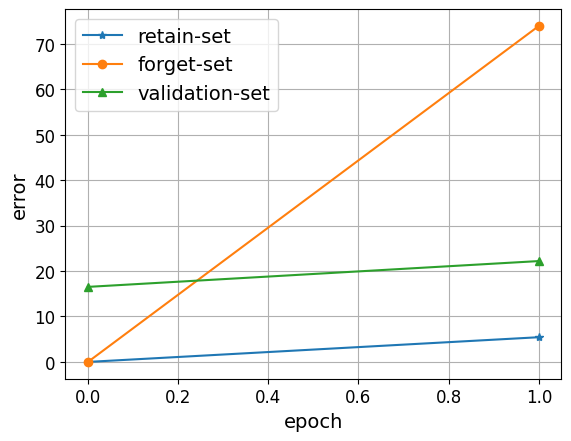

/tmp/ipykernel_770922/1431845755.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(test_losses), kde=False, norm_hist=False, rug=False, label='test-loss', ax=plt)
/tmp/ipykernel_770922/1431845755.py:116: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(forget_losses), kde=Fals

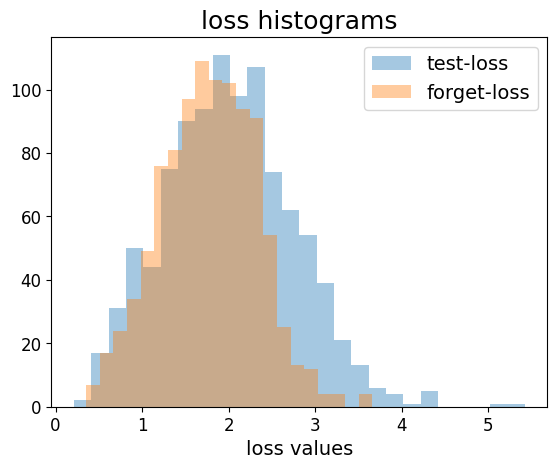

5.4221864 0.21221618
3.6593797 0.3549391
FPR:0.42, FNR:0.42, FP40.00, TN56.00, TP60.00, FN44.00
FPR:0.46, FNR:0.45, FP48.00, TN57.00, TP52.00, FN43.00
FPR:0.42, FNR:0.38, FP51.00, TN70.00, TP49.00, FN30.00
FPR:0.40, FNR:0.41, FP37.00, TN56.00, TP63.00, FN44.00
FPR:0.49, FNR:0.49, FP51.00, TN53.00, TP49.00, FN47.00


BadT ->	Full test error: 16.28	Forget error: 73.92	Retain error: 5.44	Valid error: 22.19	Fine-tune time: 1 steps	MIA: 0.57±0.0
Checkpoint name: cifar10_allcnn_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_2
[Logging in cifar10_allcnn_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_2_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 10
Epoch: [0][0/313]	Time 0.032 (0.032)	Data 0.024 (0.024)	Loss 2.3378 (2.3378)	Acc@1 10.156 (10.156)	Acc@5 55.469 (55.469)
 * Acc@1 67.615 Acc@5 96.962
Test: [0/79]	Time 0.026 (0.026)	Loss 0.8013 (0.8013)	Acc@1 71.094 (71.094)	Acc@5 97.656 (97.656)
 * Acc@1 76.680 Acc@5 99.000
Epoch Time: 11.09 sec
Epoch: [1][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.7487 (0.7487)	Acc@1 77.344 (77.344)	Acc@5 99.219 (99.219)
 * Acc@1 80.022 Acc@5 99.175
Epoch Time: 8.97 sec
Epoch: [2][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.4677 (0.4677)	Acc@1 84.375 (

 * Acc@1 99.970 Acc@5 100.000
Test: [0/79]	Time 0.026 (0.026)	Loss 0.6090 (0.6090)	Acc@1 80.469 (80.469)	Acc@5 99.219 (99.219)
 * Acc@1 78.250 Acc@5 89.530
Epoch Time: 11.03 sec
Epoch: [11][0/313]	Time 0.032 (0.032)	Data 0.024 (0.024)	Loss 0.0193 (0.0193)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.982 Acc@5 100.000
Epoch Time: 8.95 sec
Epoch: [12][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0075 (0.0075)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.993 Acc@5 100.000
Epoch Time: 8.95 sec
Epoch: [13][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0088 (0.0088)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.993 Acc@5 100.000
Epoch Time: 8.95 sec
Epoch: [14][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0059 (0.0059)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.997 Acc@5 100.000
Epoch Time: 8.94 sec
Epoch: [15][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.0045 (0.0045)	Acc@1 100.000 (100.000)	Acc@5 100.00

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 94.222 Acc@5 99.953
loss: 1.63	 train_acc: 94.22222137451172


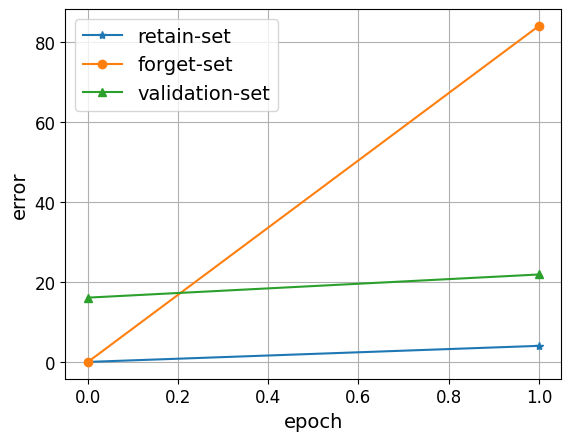

/tmp/ipykernel_770922/1431845755.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(test_losses), kde=False, norm_hist=False, rug=False, label='test-loss', ax=plt)
/tmp/ipykernel_770922/1431845755.py:116: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(forget_losses), kde=Fals

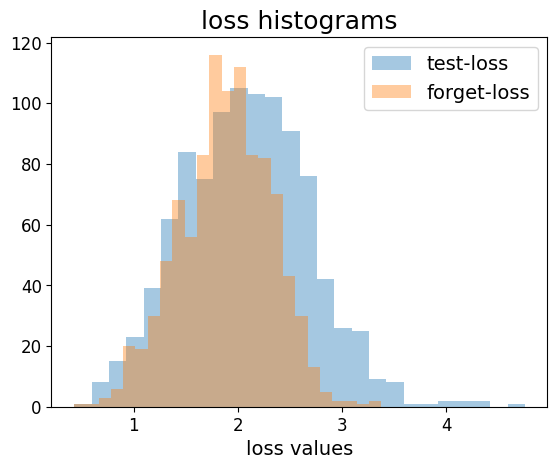

4.754534 0.42855406
3.3761232 0.4246457
FPR:0.43, FNR:0.44, FP41.00, TN54.00, TP59.00, FN46.00
FPR:0.39, FNR:0.37, FP41.00, TN65.00, TP59.00, FN35.00
FPR:0.45, FNR:0.44, FP45.00, TN56.00, TP55.00, FN44.00
FPR:0.42, FNR:0.41, FP45.00, TN62.00, TP55.00, FN38.00
FPR:0.42, FNR:0.39, FP47.00, TN66.00, TP53.00, FN34.00


BadT ->	Full test error: 15.57	Forget error: 83.92	Retain error: 4.01	Valid error: 21.84	Fine-tune time: 1 steps	MIA: 0.58±0.0
Checkpoint name: cifar10_allcnn_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_3
[Logging in cifar10_allcnn_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_3_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: train
Number of Classes: 10
Epoch: [0][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 2.5182 (2.5182)	Acc@1 8.594 (8.594)	Acc@5 44.531 (44.531)
 * Acc@1 67.485 Acc@5 96.825
Test: [0/79]	Time 0.026 (0.026)	Loss 0.8230 (0.8230)	Acc@1 72.656 (72.656)	Acc@5 98.438 (98.438)
 * Acc@1 76.970 Acc@5 98.860
Epoch Time: 10.99 sec
Epoch: [1][0/313]	Time 0.032 (0.032)	Data 0.025 (0.025)	Loss 0.5116 (0.5116)	Acc@1 80.469 (80.469)	Acc@5 100.000 (100.000)
 * Acc@1 79.997 Acc@5 99.217
Epoch Time: 8.96 sec
Epoch: [2][0/313]	Time 0.030 (0.030)	Data 0.023 (0.023)	Loss 0.5171 (0.5171)	Acc@1 82.031 (

 * Acc@1 99.967 Acc@5 100.000
Test: [0/79]	Time 0.026 (0.026)	Loss 0.4683 (0.4683)	Acc@1 87.500 (87.500)	Acc@5 99.219 (99.219)
 * Acc@1 78.100 Acc@5 89.470
Epoch Time: 11.01 sec
Epoch: [11][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.0107 (0.0107)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.982 Acc@5 100.000
Epoch Time: 8.96 sec
Epoch: [12][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.0125 (0.0125)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.993 Acc@5 100.000
Epoch Time: 8.94 sec
Epoch: [13][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.0075 (0.0075)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 99.997 Acc@5 100.000
Epoch Time: 8.95 sec
Epoch: [14][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.0112 (0.0112)	Acc@1 100.000 (100.000)	Acc@5 100.000 (100.000)
 * Acc@1 100.000 Acc@5 100.000
Epoch Time: 8.96 sec
Epoch: [15][0/313]	Time 0.031 (0.031)	Data 0.024 (0.024)	Loss 0.0053 (0.0053)	Acc@1 100.000 (100.000)	Acc@5 100.0

/home/meghdad/unlearning/SelectiveForgetting/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 94.131 Acc@5 99.939
loss: 1.66	 train_acc: 94.13055419921875


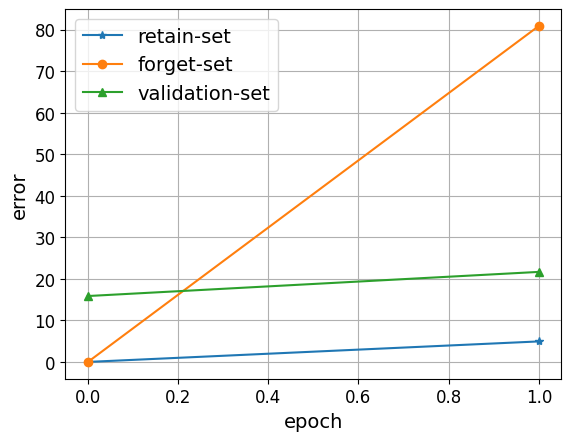

/tmp/ipykernel_770922/1431845755.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(test_losses), kde=False, norm_hist=False, rug=False, label='test-loss', ax=plt)
/tmp/ipykernel_770922/1431845755.py:116: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(forget_losses), kde=Fals

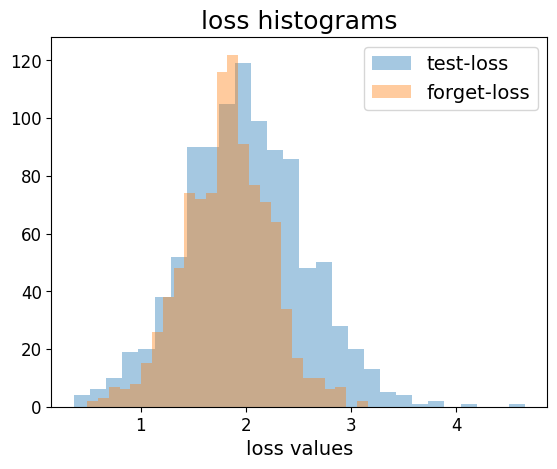

4.655567 0.36413506
3.1591437 0.48954135
FPR:0.42, FNR:0.42, FP42.00, TN58.00, TP58.00, FN42.00
FPR:0.43, FNR:0.43, FP44.00, TN58.00, TP56.00, FN42.00
FPR:0.41, FNR:0.42, FP38.00, TN55.00, TP62.00, FN45.00
FPR:0.40, FNR:0.40, FP40.00, TN60.00, TP60.00, FN40.00
FPR:0.41, FNR:0.39, FP43.00, TN63.00, TP57.00, FN37.00


BadT ->	Full test error: 15.86	Forget error: 80.87	Retain error: 4.94	Valid error: 21.67	Fine-tune time: 1 steps	MIA: 0.59±0.0


In [20]:
seeds = [1,2,3]
chkpt = "checkpoints/cifar100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt"
forget_class = '5'
forget_num = 4000
dataset = 'cifar10'
modelname = 'allcnn'
dataroot = '../image_data/cifar10'
filters = 1.0

errors = []
for s in seeds:

    %run train.py --dataset $dataset --model $modelname --dataroot=$dataroot --filters $filters --lr 0.01 \
    --resume $chkpt --disable-bn --weight-decay 0.0005 --batch-size 128 --epochs 26 --seed $s

    m_name = args.name
    %run train.py --dataset $dataset --model $modelname --split 'forget' --dataroot=$dataroot --filters $filters --lr 0.01 \
    --resume $chkpt --disable-bn --weight-decay 0.0005 --batch-size 128 --epochs 26 \
    --forget-class $forget_class --seed $s
    m0_name = args.name

    log_dict={}
    training_epochs=25
    model0 = copy.deepcopy(model)
    model_initial = copy.deepcopy(model)

    arch = args.model 
    filters=args.filters
    arch_filters = arch +'_'+ str(filters).replace('.','_')
    augment = False
    dataset = args.dataset
    class_to_forget = args.forget_class
    init_checkpoint = f"checkpoints/{args.name}_init.pt"
    num_classes=args.num_classes
    num_to_forget = args.num_to_forget
    num_total = len(train_loader.dataset)
    num_to_retain = num_total - forget_num
    seed = args.seed
    unfreeze_start = None

    learningrate=f"lr_{str(args.lr).replace('.','_')}"
    batch_size=f"_bs_{str(args.batch_size)}"
    lossfn=f"_ls_{args.lossfn}"
    wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
    seed_name=f"_seed_{args.seed}_"

    num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
    unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
    augment_tag = '' if not augment else f'augment_'

    m_name = f'checkpoints/{m_name}_{training_epochs}.pt'#f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
    m0_name = f'checkpoints/{m0_name}_{training_epochs}.pt'#f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
    

    model.load_state_dict(torch.load(m_name))
    model0.load_state_dict(torch.load(m0_name))
    model_initial.load_state_dict(torch.load(init_checkpoint))

    teacher = copy.deepcopy(model)
    bad_teacher = model_dict[args.model](num_classes=num_classes).to(args.device)
    student = copy.deepcopy(model)

    model.cuda()
    model0.cuda()


    for p in model.parameters():
        p.data0 = p.data.clone()
    for p in model0.parameters():
        p.data0 = p.data.clone()
    #train('small_cifar6', 'data/cifar10/', 'allcnn', 1.0, chkpt, forget_class, forget_num, s)
    #load_chkpts()
    
    log_dict={}
    log_dict['args']=args
    args.retain_bs = 128
    args.forget_bs = 512

    train_loader_full, valid_loader_full, test_loader_full_full, _ = datasets.get_loaders(args.dataset, batch_size=args.batch_size, seed=s, root=args.dataroot, augment=False, shuffle=True)
    marked_loader, _, test_loader_full, _ = datasets.get_loaders(args.dataset, class_to_replace=args.forget_class, num_indexes_to_replace=args.num_to_forget, only_mark=True, batch_size=1, seed=s, root=args.dataroot, augment=False, shuffle=True)

    forget_dataset = copy.deepcopy(marked_loader.dataset)
    marked = forget_dataset.targets < 0
    forget_dataset.data = forget_dataset.data[marked]
    forget_dataset.targets = - forget_dataset.targets[marked] - 1
    #forget_loader = torch.utils.data.DataLoader(forget_dataset, batch_size=args.forget_bs,num_workers=0,pin_memory=True,shuffle=True)
    forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=args.forget_bs, seed=seed, shuffle=True)

    retain_dataset = copy.deepcopy(marked_loader.dataset)
    marked = retain_dataset.targets >= 0
    retain_dataset.data = retain_dataset.data[marked]
    retain_dataset.targets = retain_dataset.targets[marked]
    #retain_loader = torch.utils.data.DataLoader(retain_dataset, batch_size=args.retain_bs,num_workers=0,pin_memory=True,shuffle=True)
    retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=args.retain_bs, seed=seed, shuffle=True)

    assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

    
    model_ft = copy.deepcopy(model)
    model_ng = copy.deepcopy(model)
    args.ft_lr = 0.04
    args.ft_epochs = 10
    args.ng_alpha = 0.9999
    args.ng_epochs = 5
    args.ng_lr = 0.01
    
    """
    bsn_blocks = [i for i in range(0,10) if i not in [3,7]]
    for i in bsn_blocks:
        for param in model_ft.features[i][0].parameters():
            param.requires_grad_(False)          
    for i in bsn_blocks:
        for param in model_ng.features[i][0].parameters():
            param.requires_grad_(False)
    for i in bsn_blocks:
        for param in student.features[i][0].parameters():
            param.requires_grad_(False)
    """
    print ("Forgetting by Fine-tuneing:")
    #finetune(model_ft, retain_loader, epochs=args.ft_epochs, quiet=True, lr=args.ft_lr)
    print ("Forgetting by NegGrad:")
    #negative_grad(model_ng, retain_loader, forget_loader, alpha=args.ng_alpha, epochs=args.ng_epochs, quiet=True, lr=args.ng_lr, args=args)
    print ("Forgetting by CFK:")
    model_cfk = 1#cfk_unlearn(model)
    print ("Forgetting by EUK:")
    model_euk = 1#euk_unlearn(model, model_initial)
    
    model_s, model_s_final = 1,1#scrub(teacher, student)
    model_bt = badt(teacher, bad_teacher, student)
    

            
    readouts = {}
    #_,_=activations_predictions(copy.deepcopy(model),forget_loader,'Original_Model_D_f')
    thresh=0#og_dict['Original_Model_D_f_loss']+1e-5
    #readouts["Original"] = all_readouts(copy.deepcopy(model),thresh,'Original', seed)
    #readouts["Retrain"] = all_readouts(copy.deepcopy(model0),thresh,'Retrain', seed)
    #readouts['Finetune'] = all_readouts(copy.deepcopy(model_ft),thresh,'Finetune', seed)
    #readouts["NegGrad"] = all_readouts(copy.deepcopy(model_ng),thresh,'NegGrad', seed)
    #readouts["CFK"] = all_readouts(copy.deepcopy(model_cfk),thresh,'CFK', seed)
    #readouts["EUK"] = all_readouts(copy.deepcopy(model_euk),thresh,'EUK', seed)
    #readouts["SCRUBS"] = all_readouts(copy.deepcopy(model_s),thresh,'SCRUBS', seed)
    #readouts["SCRUBS_final"] = all_readouts(copy.deepcopy(model_s_final),thresh,'SCRUBS_final', seed)
    readouts["BadT"] = all_readouts(copy.deepcopy(model_bt),thresh,'BadT', seed)
    
    
    del model
    del model0
    del model_ft
    del model_ng
    del model_euk
    del model_cfk
    del model_s
    del model_s_final
    del retain_loader
    del forget_loader
    del test_loader_full
    del train_loader_full

    errors.append(readouts)
    

In [21]:
tes = {}
res = {}
fes = {}
ves = {}
rlt = {}
MIA = {}
for key in errors[0].keys():
    tes[key] = [errors[i][key]['test_error'] for i in range(len(errors))]
    res[key] = [errors[i][key]['retain_error'] for i in range(len(errors))]
    fes[key] = [errors[i][key]['forget_error'] for i in range(len(errors))]
    ves[key] = [errors[i][key]['val_error'] for i in range(len(errors))]
    rlt[key] = [errors[i][key]['retrain_time'] for i in range(len(errors))]
    MIA[key] = [errors[i][key]['MIA']*100 for i in range(len(errors))]
    
    print ("{}  \t{:.2f}±{:.2f}\t{:.2f}±{:.2f}\t{:.2f}±{:.2f}\t{:.2f}±{:.2f}".format(key, 
                                                                np.mean(tes[key]), np.std(tes[key]),
                                                                np.mean(fes[key]), np.std(fes[key]),
                                                                np.mean(res[key]), np.std(res[key]),
                                                                np.mean(MIA[key]), np.std(MIA[key])))

BadT  	15.90±0.29	79.57±4.18	4.80±0.59	57.87±0.97


In [22]:
"""
total = parameter_count(model)
bsn_blocks = [i for i in range(0,10) if i not in [3,7]]
count = 0
for i in bsn_blocks:
    bn_params = 0
    conv_params = 0
    relu_params = 0
    for p in model.features[i][1].parameters():
        bn_params+=np.prod(np.array(list(p.shape)))
    for p in model.features[i][0].parameters():
        conv_params+=np.prod(np.array(list(p.shape)))
    count += bn_params + conv_params
    conv_frac = conv_params/total * 100
    bn_frac = bn_params/total * 100
    print (f'layer {i} Conv params&{conv_params}&{conv_frac:.2f}\\\\')
    print (f'layer {i} BN params&{bn_params}&{bn_frac:.2f}\\\\')
    print ('\midrule')

cls_params = 0
for p in model.classifier.parameters():
    cls_params+=np.prod(np.array(list(p.shape)))
cls_frac = cls_params/total * 100
print (f'classifier params&{cls_params}&{cls_frac:.2f}\\\\')
"""

"\ntotal = parameter_count(model)\nbsn_blocks = [i for i in range(0,10) if i not in [3,7]]\ncount = 0\nfor i in bsn_blocks:\n    bn_params = 0\n    conv_params = 0\n    relu_params = 0\n    for p in model.features[i][1].parameters():\n        bn_params+=np.prod(np.array(list(p.shape)))\n    for p in model.features[i][0].parameters():\n        conv_params+=np.prod(np.array(list(p.shape)))\n    count += bn_params + conv_params\n    conv_frac = conv_params/total * 100\n    bn_frac = bn_params/total * 100\n    print (f'layer {i} Conv params&{conv_params}&{conv_frac:.2f}\\\\')\n    print (f'layer {i} BN params&{bn_params}&{bn_frac:.2f}\\\\')\n    print ('\\midrule')\n\ncls_params = 0\nfor p in model.classifier.parameters():\n    cls_params+=np.prod(np.array(list(p.shape)))\ncls_frac = cls_params/total * 100\nprint (f'classifier params&{cls_params}&{cls_frac:.2f}\\\\')\n"